<a href="https://colab.research.google.com/github/sajaldebnath/topic_sentiment_analysis/blob/main/TopicModeling_SentimentAnalysis_LDA_using_TF_IDF_K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **IISc CCE AI/ML Capstone Project - Topic based sentiment analysis of user review data.**

### **Purpose:**
This project aims to take user reviews as inputs and figure out the following:

*   Figure out topics discussed
*   Model the topics
*   Topic clustering
*   Unsupervised sentiment analysis on each topic cluster providing Top N positive, negative, and neutral sentiment topics
*   Figuring out the Top N impactful topic for overall rating improvement

### **Approach:**

I will be using topic modeling using LDA model and then use NLTK library to calculate sentiments.

#### **Steps**
1. **Data Acquisition and Cleaning:**
  Load and preprocess the data (reviews).
   * **Gather data:** Collect a large dataset of Airbnb reviews, either through the official API or web scraping.

   * **Clean the text:** Remove stop words (common words like "the," "and," "of")
   
   * **Perform stemming or lemmatization:** To reduce words to their root form

   * **Handle contractions and special characters:** Remove special characters

   * **Tokenize the text:** Split the reviews into individual words

2. **Topic Modeling with LDA:**
  Apply LDA to identify topics in the reviews.
  * **Create a document-term matrix:** Represent each review as a bag-of-words, where each word is a feature and its frequency is the value.

  * **Train the LDA model:** Fit the LDA model to the document-term matrix, specifying the desired number of topics.

  * **Assign topics to reviews:** For each review, determine the dominant topic based on the highest probability assigned by the LDA model.

3. **Topic Assignment:** Assign reviews or sentences to topics based on the LDA
  model.

4. **Sentiment Analysis:**

  * **Utilize a sentiment analysis library:** Employ a library like VADER, TextBlob, or NLTK to calculate sentiment scores (positive, negative, or neutral) for each review.

  * **Assign sentiment to topics:** Calculate the average sentiment score for reviews assigned to each topic.

6. **Aggregate Results:** Compute sentiment scores for each topic.

7. **Analysis and Visualization:**

  * **Interpret topics:** Analyze the top words associated with each topic to understand its theme.

  * **Visualize topic distribution:** Create visualizations, such as word clouds or bar charts, to illustrate the distribution of topics within the dataset.

  * **Visualize sentiment per topic:** Use a bar chart or a radar chart to compare the sentiment scores across different topics.

### 1. **Step 1: Data Acquisition and Cleaning**


In this dataset from Kaggle https://www.kaggle.com/datasets/rhonarosecortez/new-york-airbnb-open-data/data we have 3 files:


*   calendar.csv
*   listings.csv
*   reviewes.csv

We will be working only with reviews.csv as we want to do a topic modelling on the reviews.


Apart from the above I will explore the following datasets as well (time permitting):

* [Berlin Airbnb Ratings](https://www.kaggle.com/datasets/thedevastator/berlin-airbnb-ratings-how-hosts-measure-up)

* [Google Maps Restaurant Reviews](https://www.kaggle.com/datasets/denizbilginn/google-maps-restaurant-reviews )

* [10000 Restaurant Reviews](https://www.kaggle.com/datasets/joebeachcapital/restaurant-reviews)

* [IMDB Movie Reviews with ratings](https://www.kaggle.com/datasets/nisargchodavadiya/imdb-movie-reviews-with-ratings-50k/data) (This one has the ratings and the sentiments as well. So, we can check the generated value against the actual value).


In [2]:
# @title A. Importing all necessary libraries

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import re
import nltk


In [3]:
# @title B. Gather Data - Importing and viewing the AirBnB dataset

url = 'https://raw.githubusercontent.com/sajaldebnath/topic_sentiment_analysis/refs/heads/main/data/NY-Airbnb-Open-Data-Reviews.csv'
df = pd.read_csv(url, engine='python', on_bad_lines='skip' )

df.head() # view the first 5 rows of the dataframe

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2992450,15066586,2014-07-01,16827297,Kristen,Large apartment; nice kitchen and bathroom. Ke...
1,2992450,21810844,2014-10-24,22648856,Christopher,"This may be a little late, but just to say Ken..."
2,2992450,27434334,2015-03-04,45406,Altay,The apartment was very clean and convenient to...
3,2992450,28524578,2015-03-25,5485362,John,Kenneth was ready when I got there and arrange...
4,2992450,35913434,2015-06-23,15772025,Jennifer,We were pleased to see how 2nd Street and the ...


In [4]:
# Removing the unnecessary columns since we will only be working with reviews
# later on we want to co-relate reviews with listings and perhaps with the reviewers
data = df[['listing_id','comments']]

data.head()

,listing_id,comments
0,2992450,Large apartment; nice kitchen and bathroom. Ke...
1,2992450,"This may be a little late, but just to say Ken..."
2,2992450,The apartment was very clean and convenient to...
3,2992450,Kenneth was ready when I got there and arrange...
4,2992450,We were pleased to see how 2nd Street and the ...


In [5]:
# Next let's find out the details of the dataset
data.info() #provides a summary of the data frame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24752 entries, 0 to 24751
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   listing_id  24752 non-null  int64 
 1   comments    24745 non-null  object
dtypes: int64(1), object(1)
memory usage: 386.9+ KB


In [6]:
# Next, let's check if there are any missing values
data.isna().sum()

,0
listing_id,0
comments,7


In [8]:
# Explicitly check for missing values
if (data['comments'].isnull().sum() > 0).any():
    print("Missing values found in the dataset.")
    # The best approach is to just drop them.
    data = data.dropna(subset=['comments'])
else:
    print("No missing values found in the dataset.")

data.info()

No missing values found in the dataset.
<class 'pandas.core.frame.DataFrame'>
Index: 24745 entries, 0 to 24751
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   listing_id  24745 non-null  int64 
 1   comments    24745 non-null  object
dtypes: int64(1), object(1)
memory usage: 580.0+ KB


In [9]:
data['listing_id'].nunique() # Number of unique listings. The rest of reviews of the same listings

366

### In this section we will handle the pre-processing of the date which includes the following:

* **Replacing URLs**: Links starting with "http" or "https" or "www" are replaced by "URL".

* **Replacing Emojis**: Replace emojis by using a pre-defined dictionary containing emojis along with their meaning. (eg: ":)" to "EMOJIsmile")

* **Removing Non-Alphabets**: Replacing characters except Digits and Alphabets with a space.

* **Removing Consecutive letters**: 3 or more consecutive letters are replaced by 2 letters. (eg: "Heyyyy" to "Heyy")

* **Removing Short Words**: Words with length less than 2 are removed.

* **Removing Stopwords**: Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. (eg: "the", "he", "have")

* **Lemmatizing**: Lemmatization is the process of converting a word to its base form. (e.g: “Great” to “Good”)

* **Lower Casing**: Each text is converted to lowercase.


In [10]:
# @title C. Clean the text

In [11]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [12]:
# @title * Pre-process text reviews for AirBnB Data (remove url, emojis, text patterns etc.)
def preprocess_comments(comments):

    # Defining regex patterns.
    urlPattern        = r'http[s]?://\S+' # Removes any website link starting with http or https
    alphaPattern      = "[^a-zA-Z0-9]"    # Removes text except alpha numeric patterns
    sequencePattern   = r"(.)\1\1+"       # Finds out 3 or more repeating letters likes "aaa"
    seqReplacePattern = r"\1\1"           # Replace the repeating letter sequence with two letters
    symbolPattern = r'Ã[^\x80-\xBF]+'     # Finds out the special characters like Ã
    spacePattern = r'\s+'                 # Finds out extra spaces betweem words
    brtags = r"<br ?/?>"                  # Finds out all the <br/>, <br>, </br> tags
    daysPattern = r'\d+(st|nd|rd|th)'     # \d+: Matches one or more digits. (st|nd|rd|th): Matches the suffixes "st", "nd", "rd", or "th".

    # Replace all URls with ' '
    comments = re.sub(urlPattern, '', comments, flags=re.MULTILINE)
    # Replace <br/>, <br>, </br> with " "
    comments = re.sub(brtags, ' ', comments)
    # Replace all non alphabets.
    comments = re.sub(alphaPattern, " ", comments)
    # Replace 3 or more consecutive letters by 2 letters.
    comments = re.sub(sequencePattern, seqReplacePattern, comments)
    # Replace special encoded symbols that appear as characters like Ã, Å, Ë
    comments = re.sub(symbolPattern, ' ', comments)
    # Replace days patterns like 2nd, 3rd, 4th etc.
    comments = re.sub(daysPattern, ' ', comments)

    # Replace all emojis.
    for emoji in emojis.keys():
      comments = comments.replace(emoji, " " + emojis[emoji])

    # Replace multiple spaces with a single space
    comments = re.sub(spacePattern, ' ', comments)
    # Remove all leading or trailing spaces
    comments = comments.strip()

    return comments.lower()  # Convert all to lowercase

In [13]:
# Pre-process text reviews for AirBnB Data
import time
t = time.time()
data['processed_comments'] = data['comments'].apply(preprocess_comments) #applying the preprocess_comments function to comments column

print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 2 seconds


In [14]:
#VIEW THE CLEANED Comments IN "comments" column again
pd.set_option('display.max_colwidth', None) #to view text fully and so that
#pandas doesn't truncate the text

data.head() # Printing the data to see the updated result

,listing_id,comments,processed_comments
0,2992450,"Large apartment; nice kitchen and bathroom. Kenneth left drinks for us which was so nice. His cousin lives upstairs, and she was very nice and helpful, too. The internet only worked about half the time, and everything on the street can be heard from the main bedroom. Wonderful stay- it was exactly what we needed. It is not in the best area of town, but I never felt unsafe.",large apartment nice kitchen and bathroom kenneth left drinks for us which was so nice his cousin lives upstairs and she was very nice and helpful too the internet only worked about half the time and everything on the street can be heard from the main bedroom wonderful stay it was exactly what we needed it is not in the best area of town but i never felt unsafe
1,2992450,"This may be a little late, but just to say Kenneth was quick to respond to our request. He left some supplies in the refrigerator and kindly showed us round downtown Albany. We were without a car and he arranged for his cousin Kristina to take us to supermarket.\r<br/>The apartment is large, clean with many original features. It is situated in an historical area that is fairly central, although like the rest of Albany you have to climb a steep hill to get to it if you are on foot. \r<br/>",this may be a little late but just to say kenneth was quick to respond to our request he left some supplies in the refrigerator and kindly showed us round downtown albany we were without a car and he arranged for his cousin kristina to take us to supermarket the apartment is large clean with many original features it is situated in an historical area that is fairly central although like the rest of albany you have to climb a steep hill to get to it if you are on foot
2,2992450,"The apartment was very clean and convenient to downtown. One thing to keep in mind: one bedroom is huge and the other is tiny, so if you're traveling with a friend you might have to flip a coin. :)",the apartment was very clean and convenient to downtown one thing to keep in mind one bedroom is huge and the other is tiny so if you re traveling with a friend you might have to flip a coin
3,2992450,"Kenneth was ready when I got there and arranged for the upstairs neighbor to meet me at the door with the keys. Shortly after that I was left on my own in the privacy of this large 2 BR apartment - just like I like it. I really like my privacy and there was no time at which anyone came to visit me or bother me unannounced. At one point Kenneth had to pic up a refrigerator stored in the apartment, but the neighbor lady gave me plenty of notice and I was on my way out before he got there. When I returned the extra refrigerator was gone and I had the nice quiet apartment to myself. At one point I went to take a shower and found some body wash in a drawer. That was nice since all I brought with me was shampoo. The apartment is a city street apartment meaning that like many two family homes the BR window is feet away from the public sidewalk and you can hear people all hours of the night walking by and conversing, but its not terribly disruptive. Overall the apartment was just what I needed and I had an enjoyable time while there. The heat worked perfectly and the apartment was picked up. The bed was a king size and very comfortable with sensible pillows and coverings. The water pressure on the shower was awesome.",kenneth was ready when i got there and arranged for the upstairs neighbor to meet me at the door with the keys shortly after that i was left on my own in the privacy of this large 2 br apartment just like i like it i really like my privacy and there was no time at which anyone came to visit me or bother me unannounced at one point kenneth had to pic up a refrigerator stored in the apartment but the neighbor lady gave me plenty of notice and i was on my way out before he got there when i returned the extra refrigerator was gone and i had the nice quiet apartment to myself at one poi

In [15]:
# @title D. Remove stopwords
import string

# Download the stopwords list
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

#Let's define a list of custom_stop_words which does not add value to the topic
custom_stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves', 'us']


# Get the stop words from the defined library
stop_words = stopwords.words("english")

# Generate a stop words list using both library and customer stopwords
updated_stops = stop_words+custom_stopwordlist

# Define the function to remove the stopwords from the texts
# Removes all stop words, including custom words
def remove_stop_words(review):

   # Get the words from the review
    words = review.split()
    final = []
    for word in words:
        if word not in updated_stops:
            # Lemmatizing the words
            word = lemmatizer.lemmatize(word, pos='v') # Lemmatize as a verb, pos='v' ensures that
            final.append(word)

    #reassembles the text without stop words
    final = " ".join(final)

    #removes all punctuation
    final = final.translate(str.maketrans("", "", string.punctuation))

    #removes all numbers
    final = "".join([i for i in final if not i.isdigit()])

    #eliminates double white spaces
    while "  " in final:
        final = final.replace("  ", " ")
    return (final)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [16]:
# @title Remove stopwords from the original text and lemmatize them
data['filtered_comments'] = data['processed_comments'].apply(remove_stop_words)

print(f'Removing stopwords from processed_comments and lemmatizing them complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')


Removing stopwords from processed_comments and lemmatizing them complete.
Time Taken: 22 seconds


In [17]:
# Let's check the updated data again
data.head()

,listing_id,comments,processed_comments,filtered_comments
0,2992450,"Large apartment; nice kitchen and bathroom. Kenneth left drinks for us which was so nice. His cousin lives upstairs, and she was very nice and helpful, too. The internet only worked about half the time, and everything on the street can be heard from the main bedroom. Wonderful stay- it was exactly what we needed. It is not in the best area of town, but I never felt unsafe.",large apartment nice kitchen and bathroom kenneth left drinks for us which was so nice his cousin lives upstairs and she was very nice and helpful too the internet only worked about half the time and everything on the street can be heard from the main bedroom wonderful stay it was exactly what we needed it is not in the best area of town but i never felt unsafe,large apartment nice kitchen bathroom kenneth leave drink nice cousin live upstairs nice helpful internet work half time everything street hear main bedroom wonderful stay exactly need best area town never felt unsafe
1,2992450,"This may be a little late, but just to say Kenneth was quick to respond to our request. He left some supplies in the refrigerator and kindly showed us round downtown Albany. We were without a car and he arranged for his cousin Kristina to take us to supermarket.\r<br/>The apartment is large, clean with many original features. It is situated in an historical area that is fairly central, although like the rest of Albany you have to climb a steep hill to get to it if you are on foot. \r<br/>",this may be a little late but just to say kenneth was quick to respond to our request he left some supplies in the refrigerator and kindly showed us round downtown albany we were without a car and he arranged for his cousin kristina to take us to supermarket the apartment is large clean with many original features it is situated in an historical area that is fairly central although like the rest of albany you have to climb a steep hill to get to it if you are on foot,may little late say kenneth quick respond request leave supply refrigerator kindly show round downtown albany without car arrange cousin kristina take supermarket apartment large clean many original feature situate historical area fairly central although like rest albany climb steep hill get foot
2,2992450,"The apartment was very clean and convenient to downtown. One thing to keep in mind: one bedroom is huge and the other is tiny, so if you're traveling with a friend you might have to flip a coin. :)",the apartment was very clean and convenient to downtown one thing to keep in mind one bedroom is huge and the other is tiny so if you re traveling with a friend you might have to flip a coin,apartment clean convenient downtown one thing keep mind one bedroom huge tiny travel friend might flip coin
3,2992450,"Kenneth was ready when I got there and arranged for the upstairs neighbor to meet me at the door with the keys. Shortly after that I was left on my own in the privacy of this large 2 BR apartment - just like I like it. I really like my privacy and there was no time at which anyone came to visit me or bother me unannounced. At one point Kenneth had to pic up a refrigerator stored in the apartment, but the neighbor lady gave me plenty of notice and I was on my way out before he got there. When I returned the extra refrigerator was gone and I had the nice quiet apartment to myself. At one point I went to take a shower and found some body wash in a drawer. That was nice since all I brought with me was shampoo. The apartment is a city street apartment meaning that like many two family homes the BR window is feet away from the public sidewalk and you can hear people all hours of the night walking by and conversing, but its not terribly disruptive. Overall the apartment was just what I needed and I had an enjoyable time while there. The heat worked perfectly and the apartment was picked up. The bed was a king size and very comfortable with sensible pillows and cove

In [18]:
# @title Perform TF-IDF and KMeans Clustering

In [19]:
data['filtered_comments']

,filtered_comments
0,large apartment nice kitchen bathroom kenneth leave drink nice cousin live upstairs nice helpful internet work half time everything street hear main bedroom wonderful stay exactly need best area town never felt unsafe
1,may little late say kenneth quick respond request leave supply refrigerator kindly show round downtown albany without car arrange cousin kristina take supermarket apartment large clean many original feature situate historical area fairly central although like rest albany climb steep hill get foot
2,apartment clean convenient downtown one thing keep mind one bedroom huge tiny travel friend might flip coin
3,kenneth ready get arrange upstairs neighbor meet door key shortly leave privacy large br apartment like like really like privacy time anyone come visit bother unannounced one point kenneth pic refrigerator store apartment neighbor lady give plenty notice way get return extra refrigerator go nice quiet apartment one point go take shower find body wash drawer nice since bring shampoo apartment city street apartment mean like many two family home br window feet away public sidewalk hear people hours night walk converse terribly disruptive overall apartment need enjoyable time heat work perfectly apartment pick bed king size comfortable sensible pillow coverings water pressure shower awesome
4,please see street ten broeck neighborhood albany come along great see gorgeous brownstones include one stay renovate care term quality please courtesy host friend live nearby let make sure know call problems full kitchen two bedrooms daughter felt home plenty space native albany use thin windows occasionally noisy neighbor sleep well take master bedroom aware loud music may play even weekend fan ac unit drown din street space renovate vast improvement sure hop progress continue seem project incomplete would love enjoy sunlight house ton tree debris back yard way enjoy open windows place fine travel child probably pick quieter location able open windows put nap without worry excessive noise
...,...
24747,stay great everyone super friendly house comfortable area quiet safe overall definitely recommend place
24748,apartment affordable seem clean host responsive texts call could good choice travelers budget mind rougher surroundings good experience address provide incorrect call host find place actually apartment picture inside neighborhood rundown many surround house poor condition approach drink unpack car park almost block away would park across street neighbor tell would get ticket host mention floor walk expect step really narrow wind extent felt unsafe carry bag break tile kitchen entryway move step walk bedroom get bathroom leave find another place stay
24749,good place stay stay overnight work work well need location felt safe lot street park check super simple instructions clear couple minor things place bathroom door lock break floor tile kitchen also checkout instructions unsure everything host need checkout overall solid airbnb consider future work trip
24750,need place crash day close downtown great simple price accordingly street get little loud night fault list host


In [ ]:
# @title Apply TF-IDF

vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(data['filtered_comments'])

# Perform KMeans Clustering for topics
num_topics = 4  # Number of topics to extract
kmeans = KMeans(n_clusters=num_topics, random_state=42)
data['topic'] = kmeans.fit_predict(X)

# Get top terms per topic
def get_top_terms_per_topic(model, feature_names, n_top_words):
    top_terms = []
    for cluster_idx in range(model.n_clusters):
        cluster_center = model.cluster_centers_[cluster_idx]
        terms = [feature_names[i] for i in cluster_center.argsort()[-n_top_words:]]
        top_terms.append(terms)
    return top_terms

feature_names = vectorizer.get_feature_names_out()
top_terms = get_top_terms_per_topic(kmeans, feature_names, 5)
for idx, terms in enumerate(top_terms):
    print(f"Topic {idx + 1}: {', '.join(terms)}")

Topic 1: host, comfortable, clean, place, stay
Topic 2: great, clean, stay, place, nice
Topic 3: host, stay, place, location, great
Topic 4: location, host, place, stay, great


In [ ]:
# @title Sentiment Analysis

# Calculate sentiment for each review
data['sentiment_score'] = data['filtered_comments'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Group sentiment by topic
topic_sentiment = data.groupby('topic')['sentiment_score'].mean()

In [ ]:
# @title Visualize the Data

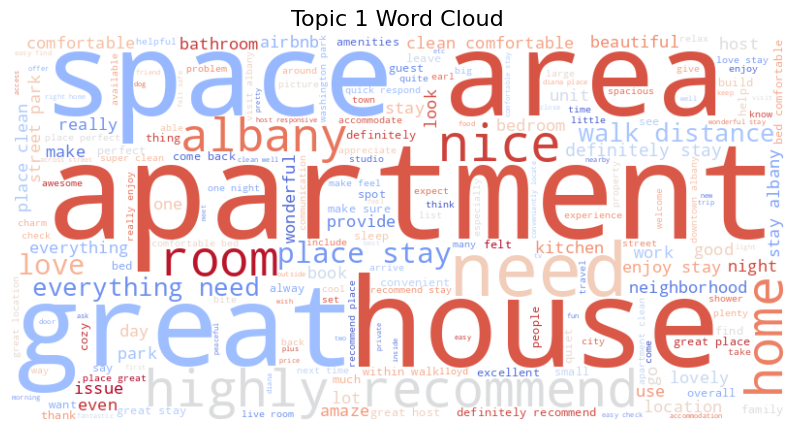

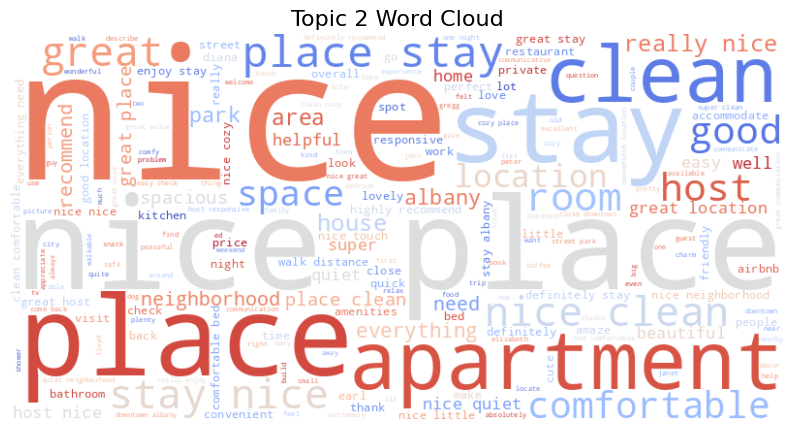

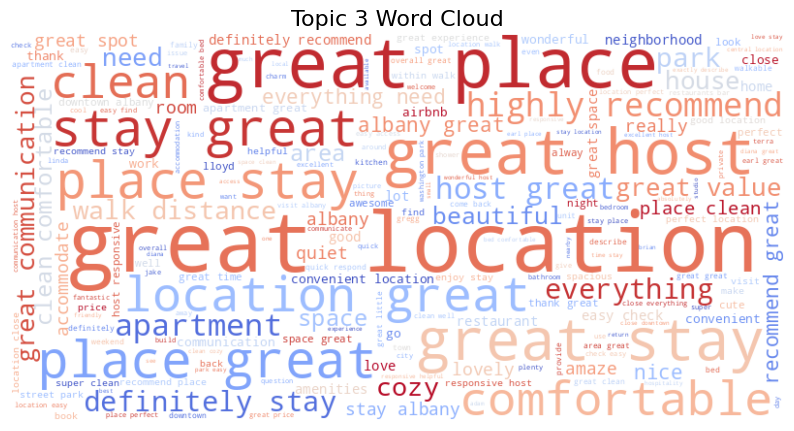

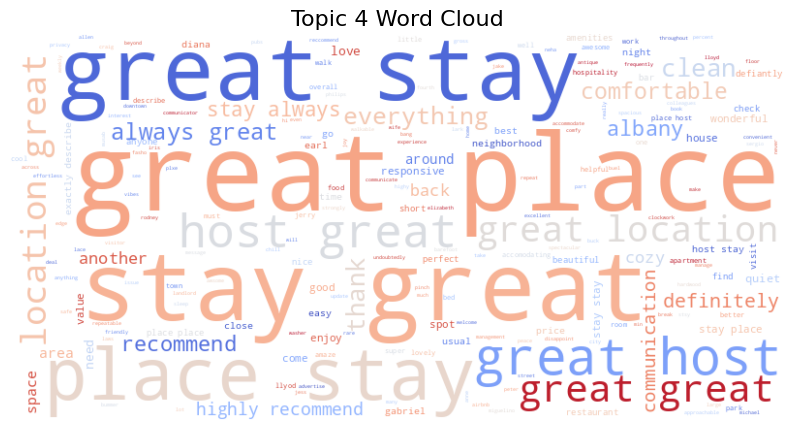

In [ ]:
# @title Word Clouds for Topics
for topic_idx in range(num_topics):
    topic_reviews = " ".join(data[data['topic'] == topic_idx]['filtered_comments'])
    wordcloud = WordCloud(
        background_color='white',
        colormap='coolwarm',
        width=800,
        height=400
    ).generate(topic_reviews)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {topic_idx + 1} Word Cloud', fontsize=16)
    plt.show()

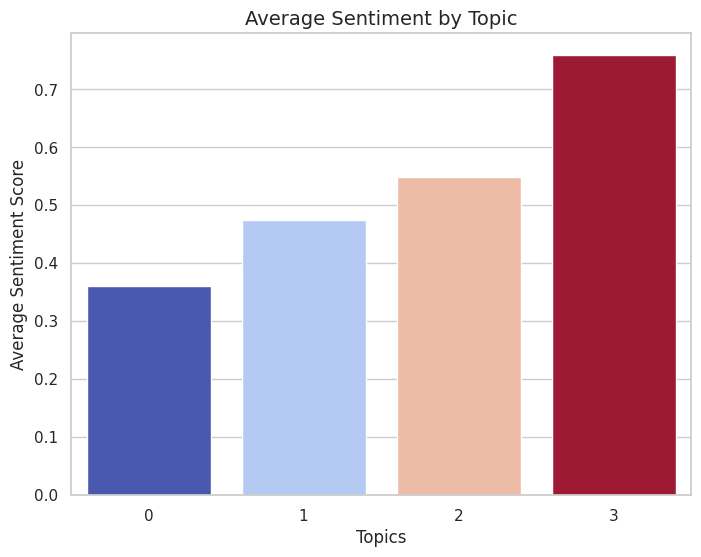

In [ ]:
# @title Sentiment by Topic - Bar Plot
# Bar plot for topic sentiment
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(x=topic_sentiment.index, hue=topic_sentiment.index, y=topic_sentiment.values, palette='coolwarm', legend=False)
plt.title('Average Sentiment by Topic', fontsize=14)
plt.xlabel('Topics')
plt.ylabel('Average Sentiment Score')
plt.axhline(0, color='black', linestyle='--', linewidth=0.7)
plt.show()

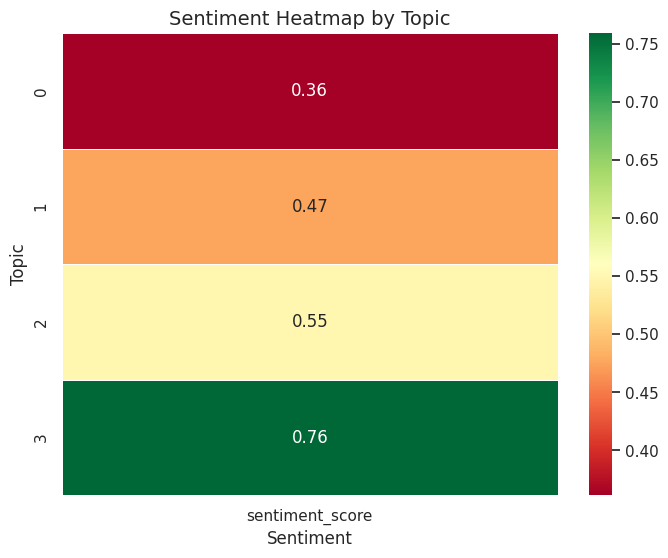

In [ ]:
# @title Sentiment Heatmap

# Pivot data for heatmap
topic_sentiment_pivot = data.pivot_table(
    index='topic',
    values='sentiment_score',
    aggfunc='mean'
)

plt.figure(figsize=(8, 6))
sns.heatmap(
    topic_sentiment_pivot,
    annot=True,
    cmap='RdYlGn',
    cbar=True,
    linewidths=0.5
)
plt.title("Sentiment Heatmap by Topic", fontsize=14)
plt.xlabel("Sentiment")
plt.ylabel("Topic")
plt.show()